# Midterm 1

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

# Instructions

## Please note the following:

Points
* The exam is `100` points.
* You have `125` minutes to complete the exam.
* For every minute late you submit the exam, you will lose one point.


Submission
* You will upload your solution to the `Midterm 1` assignment on Canvas, where you downloaded this. (Be sure to **submit** on Canvas, not just **save** on Canvas.
* Your submission should be readable, (the graders can understand your answers,)
* and it should **include all code used in your analysis in a file format that the code can be executed.** 

Rules
* The exam is open-material, closed-communication.
* You do not need to cite material from the course github repo--you are welcome to use the code posted there without citation.

Advice
* If you find any question to be unclear, state your interpretation and proceed. We will only answer questions of interpretation if there is a typo, error, etc.
* The exam will be graded for partial credit.

## Data

**All data files are found in the class github repo, in the `data` folder.**

This exam makes use of the following data files:
* `midterm_1_data.xlsx`

This file has sheets for...
* `stocks excess returns` - excess returns of the 14 biggest companies in the S&P.
* `proshares excess returns` - excess returns of ETFs and indexes from the Proshares case study.
* `fx carry excess returns` - excess returns from FX products.

Note the data is **monthly** for the first two sheets (stocks and proshares). Any annualizations for those two sheets should use `12` months in a year. Annualization for the third sheet (fx carry excess returns) is explained in section 4.

## Scoring

| Problem | Points |
|---------|--------|
| 1       | 15     |
| 2       | 25     |
| 3       | 35     |
| 4       | 25     |

### Each numbered question is worth 5 points unless otherwise specified.

***

# 1. Short Answer

#### No Data Needed

These problems do not require any data file. Rather, analyze them conceptually. 

### 1.

#### (10pts)

In the mean-variance optimization of `homework 1`, suppose we found the mean excess return of TIPS is 4% annualized.

Explain--conceptually--how each of the following would have impacted the new (with TIPS) MV solution.
* TIPS is found to have correlation of 0% to `IEF` and 0% to SPY.
* TIPS is found to have correlation of 100% to `IEF`.

Would it be possible for TIPS to have been found to have 0% correlation to every other asset in `homework 1`? Explain.

If Tips exhibit zero correlation with other assets, It implies that it does not move in tandem to IEF and SPY. Therefore, might be highly beneficial for diversification purposes. Incorporating an asset with zero correlation can potentially reduce the overall portfolio volatility without sacrificing expected returns, as TIPS can offset risks associated with movements in IEF and SPY. Marginal effect of portfolio variance is low.

If have a 100% correlation with IEF, this would imply that TIPS and IEF move perfectly in sync; when IEF’s returns increase or decrease, TIPS’ returns would do exactly the same. This perfect correlation typically reduces the diversification benefit of adding TIPS to the portfolio because it does not provide any new variance reduction advantage over holding IEF alone.

It is highlu unlikely to be 0% correlation with every other asset, as this will mean it has isolated factors. Since TIPS (returns) is affected by inflation and most assets in the financial markets are interconnected, and various economic factors like interest rates, inflation, economic growth, and market sentiment generally influence asset returns. These shared influences tend to induce some level of correlation among asset returns. TIPS as government-backed securities with returns tied to inflation rates that also affect other economic variables and asset classes.

### 2. 

Depending on the application, one may or may not choose to include an intercept term in a linear factor decomposition of an asset’s returns. In what circumstances would I prefer to include an intercept, and in what circumstances would I not?

One would prefer to add an intercept if the goal is to explain the variability of the data rather than the level. By including intercept, one focuses on explaining variability. However, in the case of replication, one might want  to only use tradeable assets. However, the intercet is not a tradeable security.

***

# 2. Portfolio Allocation

For this question you will only use data from the sheet `stocks excess returns`.

It contains excess returns for the 14 largest stocks in the S&P.

### 1.

Calculate the tangency portfolio from the start of the sample to December of 2018 (to 2018-12-31), which we call in-sample period. Use the following methods:
- Traditional tangency portfolio.
- Regularized tangency portfolio (divide by 2 every element outside of the diagonal in the covariance matrix prior to the calculation).

Return:
- The weights of each asset for the traditional tangency portfolio and the regularized tangency portfolio.
- The sum of absolute values of the weights for the traditional tangency portfolio and the regularized tangency portfolio:

$$
\sum_{i=1}^{n} |w_i|
$$


In [1]:
import numpy as np
import os
from arch import arch_model
import re
import sys
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import os
import sys
from typing import Tuple, Dict, Union, Callable
notebook_dir = "Exam"
if os.path.basename(os.getcwd()) == notebook_dir:
    os.chdir(os.pardir)  # Change to parent directory
    sys.path.append(os.getcwd())  # Add the new current directory to sys.path

import cmds.portfolio_management_helper as pmh
import functions.functions_andy as fa
print(os.getcwd())

from sklearn.linear_model import LinearRegression
from dask.distributed import Client, wait
# From HW1
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.metrics import r2_score
from scipy.stats import describe



c:\Users\Andik\OneDrive\Desktop\Chicago\Portfolio theory and risk management\githubrepo\finm-portfolio-2024


In [4]:
data = fa.load_data(filename="midterm_1_data.xlsx",
                    path = "./data",
                    sheet_name='stocks excess returns')
data.set_index("date", inplace=True)
data.tail()

,AAPL,AMZN,BRK-B,GOOGL,JNJ,JPM,LLY,META,MSFT,NVDA,TSLA,UNH,V,XOM
date,,,,,,,,,,,,,,
2024-05-31,0.1256,0.0036,0.0400,0.0551,0.0180,0.0522,0.0474,0.0806,0.0636,0.2643,-0.0330,0.0195,0.0116,-0.0051
2024-06-30,0.0914,0.0911,-0.0225,0.0530,-0.0077,-0.0060,0.0995,0.0770,0.0725,0.1227,0.1070,0.0282,-0.0409,-0.0224
2024-07-31,0.0498,-0.0370,0.0733,-0.0628,0.0754,0.0533,-0.1163,-0.0629,-0.0686,-0.0574,0.1682,0.1268,0.0076,0.0255
2024-08-31,0.0274,-0.0503,0.0804,-0.0525,0.0537,0.0514,0.1903,0.0929,-0.0061,0.0151,-0.0824,0.0194,0.0374,-0.0025
2024-09-30,-0.0099,0.0485,-0.0434,0.0002,-0.0315,-0.0682,-0.0902,0.0848,0.0215,0.0125,0.2119,-0.0152,-0.0089,-0.0226


In [ ]:

def calculate_various_portfolio_metrics(
    data: pd.DataFrame, 
    target: float = 0.12, 
    annual_factor: int = 12, 
    use_pmh: bool = False
) -> pd.DataFrame:
    """
    Calculate various portfolio metrics for Tangency, Equal Weighted, Risk Parity, and Regularized portfolios.

    Parameters:
    - data (pd.DataFrame): The input data containing asset returns.
    - target (float): The target annualized mean return. Default is 0.12.
    - annual_factor (int): The factor used for annualizing returns and volatility. Default is 12 (monthly).
    - use_pmh (bool): If True, uses the `pmh` methods to compute the portfolios. Default is False.
    
    Returns:
    - pd.DataFrame: A DataFrame with annualized mean, volatility, and Sharpe ratio for each portfolio.
    
    Example:
    ```
    metrics = calculate_various_portfolio_metrics(data, target=0.1, annual_factor=12)
    metrics_pmh = calculate_various_portfolio_metrics(data, use_pmh=True)
    ```
    """
    if use_pmh:
        try:
            n_assets = len(data.columns)
            # Equal Weights Portfolio
            portfolio_equal_weights = pmh.create_portfolio(
                data, weights=[1 / n_assets for _ in range(n_assets)], port_name="Equal Weights"
            ) * target / pmh.create_portfolio(data, weights=[1 / n_assets for _ in range(n_assets)]).mean()

            # Risk Parity Portfolio
            asset_variance_dict = data.std().map(lambda x: x ** 2).to_dict()
            asset_inv_variance_dict = {asset: 1 / variance for asset, variance in asset_variance_dict.items()}
            portfolio_risk_parity = pmh.create_portfolio(
                data, weights=asset_inv_variance_dict, port_name="Risk Parity"
            ) * target / pmh.create_portfolio(data, weights=asset_inv_variance_dict).mean()

            # Tangency Portfolio
            portfolio_tangency = pmh.calc_tangency_weights(data, return_port_ret=True) * target / pmh.calc_tangency_weights(data, return_port_ret=True).mean()

            # Regularized Portfolio
            portfolio_regularized = pmh.calc_tangency_weights(
                data, return_port_ret=True, cov_mat=0.5, name="Regularized"
            ) * target / pmh.calc_tangency_weights(data, return_port_ret=True, cov_mat=0.5).mean()

            # Compile results
            portfolios = pd.concat(
                [portfolio_equal_weights, portfolio_risk_parity, portfolio_tangency, portfolio_regularized], axis=1
            )
            return pmh.calc_summary_statistics(
                portfolios, provided_excess_returns=True, annual_factor=annual_factor, keep_columns=['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe']
            )

        except Exception as e:
            raise Exception(f"An error occurred when using pmh methods: {e}")

    try:
        # Tangency Portfolio
        tangency_weights = np.linalg.inv(data.cov()) @ data.mean()
        tangency_portfolio_mean = data.mean() @ tangency_weights * annual_factor
        scaled_tangency_weights = (target / tangency_portfolio_mean) * tangency_weights
        tangency_mean = scaled_tangency_weights @ data.mean() * annual_factor
        tangency_vol = np.sqrt(scaled_tangency_weights @ data.cov() @ scaled_tangency_weights) * np.sqrt(annual_factor)
        tangency_sharpe = tangency_mean / tangency_vol
        Tangency_df = pd.DataFrame(
            {"Tangency": [tangency_mean, tangency_vol, tangency_sharpe]},
            index=["Annualised_Mean", "Annualised_Vol", "Annualised_Sharpe"]
        )

        # Equal Weighted Portfolio
        number_of_securities = data.columns.size
        equal_weights = np.repeat(1 / number_of_securities, number_of_securities)
        equal_weight_portfolio_mean = data.mean() @ equal_weights * annual_factor
        scaled_equal_weights = (target / equal_weight_portfolio_mean) * equal_weights
        ew_mean = scaled_equal_weights @ data.mean() * annual_factor
        ew_vol = np.sqrt(scaled_equal_weights @ data.cov() @ scaled_equal_weights) * np.sqrt(annual_factor)
        ew_sharpe = ew_mean / ew_vol
        EW_df = pd.DataFrame(
            {"EW": [ew_mean, ew_vol, ew_sharpe]},
            index=["Annualised_Mean", "Annualised_Vol", "Annualised_Sharpe"]
        )

        # Risk Parity Portfolio
        data_variance = data.var()
        rp_weights = 1 / data_variance
        risk_parity_portfolio_mean = data.mean() @ rp_weights * annual_factor
        scaled_risk_parity = (target / risk_parity_portfolio_mean) * rp_weights
        rp_mean = scaled_risk_parity @ data.mean() * annual_factor
        rp_vol = np.sqrt(scaled_risk_parity @ data.cov() @ scaled_risk_parity) * np.sqrt(annual_factor)
        rp_sharpe = rp_mean / rp_vol
        RP_df = pd.DataFrame(
            {"RP": [rp_mean, rp_vol, rp_sharpe]},
            index=["Annualised_Mean", "Annualised_Vol", "Annualised_Sharpe"]
        )

        # Regularized Portfolio
        reg_cov_matrix = (data.cov() + np.diag(np.diag(data.cov()))) / 2
        reg_weights = np.linalg.inv(reg_cov_matrix) @ data.mean()
        reg_portfolio_mean = data.mean() @ reg_weights * annual_factor
        scaled_reg_weights = (target / reg_portfolio_mean) * reg_weights
        reg_mean = scaled_reg_weights @ data.mean() * annual_factor
        reg_vol = np.sqrt(scaled_reg_weights @ data.cov() @ scaled_reg_weights) * np.sqrt(annual_factor)
        reg_sharpe = reg_mean / reg_vol
        Reg_df = pd.DataFrame(
            {"Reg": [reg_mean, reg_vol, reg_sharpe]},
            index=["Annualised_Mean", "Annualised_Vol", "Annualised_Sharpe"]
        )

        # Compile results and show correlations heatmap
        result_df = pd.concat([Tangency_df, EW_df, RP_df, Reg_df], axis=1).T
        
        # Calculate weighted returns and show correlation heatmap
        array_of_weights = np.array(
            [scaled_tangency_weights, scaled_equal_weights, scaled_risk_parity, scaled_reg_weights]
        )
        weighted_return_data = (data @ array_of_weights.T).rename(columns={0: "Tangency", 1: "EW", 2: "RP", 3: "Reg"})
        sns.heatmap(weighted_return_data.corr(), annot=True)
        plt.show()
        
        return result_df

    except Exception as e:
        raise Exception(f"An error occurred when calculating portfolio metrics: {e}")



In [8]:
end_date = pd.to_datetime("2018-12-31")
filtered_data = data.loc[:end_date,:]
annual_factor = 12
# Tangency Portfolio
tangency = pmh.calc_tangency_weights(returns = filtered_data,
                          annual_factor=12,
                          name = "Tangency")
display(tangency)
sum_of_absolute_tangency = tangency["Tangency Weights"].abs().sum()
print(f"Sum of absolute tangency weights: {sum_of_absolute_tangency}")

,Tangency Weights
AAPL,-0.1278
AMZN,-0.0406
BRK-B,0.1313
GOOGL,0.0260
JNJ,0.1304
JPM,-0.0139
LLY,0.3527
META,0.0305
MSFT,0.1379
NVDA,0.1635


Sum of absolute tangency weights: 2.1976870785297877


In [9]:
# Regularized portfolio
regularized_portfolio = pmh.calc_tangency_weights(returns = filtered_data,
                                                  cov_mat=0.5,
                                                    annual_factor=12,
                                                    name="Reg")
display(regularized_portfolio)
sum_of_absolute_regularized = regularized_portfolio["Reg Weights"].abs().sum()
print(f"Sum of absolute regularized weights: {sum_of_absolute_regularized}")

,Reg Weights
AAPL,-0.0147
AMZN,0.0363
BRK-B,0.1092
GOOGL,0.0505
JNJ,0.0992
JPM,0.0537
LLY,0.2149
META,0.0349
MSFT,0.0900
NVDA,0.0717


Sum of absolute regularized weights: 1.3426467125901398


### 2.

Calculate the annualized summary statistics (mean, Sharpe, vol) of both portfolios in-sample.


In [16]:
print(filtered_data.shape)
print(regularized_portfolio.size)
# Tangency_weighted_returns
tangency_weighted_returns = (filtered_data @ tangency["Tangency Weights"]).to_frame("Tangency_Weighted_Returns")
tangency_stats = pmh.calc_summary_statistics(returns=tangency_weighted_returns, annual_factor=12)
display(tangency_stats)

(79, 14)
14
Assuming excess returns were provided to calculate Sharpe. If returns were provided (steady of excess returns), the column "Sharpe" is actually "Mean/Volatility"


,Mean,Annualized Mean,Vol,Annualized Vol,Sharpe,Annualized Sharpe,Min,Max,Skewness,Excess Kurtosis,...,Annualized Historical VaR (5.00%),Historical CVaR (5.00%),Annualized Historical CVaR (5.00%),Max Drawdown,Peak,Bottom,Tangency Weights,Recovery,Duration (days),Tangency_Weighted_Returns Correlation
Tangency_Weighted_Returns,0.0290,0.3483,0.0387,0.1341,0.7499,2.5979,-0.0601,0.1082,-0.1903,-0.5220,...,-0.1380,-0.0509,-0.1764,-0.0805,2015-12-31,2016-02-29,1.0000,2016-05-31,92,1.0000


In [17]:
# Regularized_weighted_returns
regularized_weighted_returns = (filtered_data @ regularized_portfolio["Reg Weights"]).to_frame("Regularized_Weighted_Returns")
regularized_stats = pmh.calc_summary_statistics(returns=regularized_weighted_returns, annual_factor=12)
display(regularized_stats)

Assuming excess returns were provided to calculate Sharpe. If returns were provided (steady of excess returns), the column "Sharpe" is actually "Mean/Volatility"


,Mean,Annualized Mean,Vol,Annualized Vol,Sharpe,Annualized Sharpe,Min,Max,Skewness,Excess Kurtosis,...,Annualized Historical VaR (5.00%),Historical CVaR (5.00%),Annualized Historical CVaR (5.00%),Max Drawdown,Peak,Bottom,Tangency Weights,Recovery,Duration (days),Regularized_Weighted_Returns Correlation
Regularized_Weighted_Returns,0.0230,0.2766,0.0330,0.1142,0.6993,2.4224,-0.0753,0.0804,-0.4691,-0.1033,...,-0.1325,-0.0517,-0.1790,-0.0791,2018-08-31,2018-12-31,1.0000,NaT,NaN,1.0000


### 3.

Use the weights calculated in question (2.2) to produce portfolio returns out-of-sample for both the Traditional and Regularized portfolio (from January 2019 onwards). 

Report the **last 3 returns** of both portfolios in the out-of-sample (the traditional tangency portfolio and the regularized tangency portfolio).

In [18]:
oos_start_date = pd.to_datetime("2019-01-01")
oos_data = data.loc[oos_start_date:,:]
oos_data.head()

,AAPL,AMZN,BRK-B,GOOGL,JNJ,JPM,LLY,META,MSFT,NVDA,TSLA,UNH,V,XOM
date,,,,,,,,,,,,,,
2019-01-31,0.0527,0.1419,0.0042,0.0750,0.0288,0.0664,0.0333,0.2691,0.0257,0.0743,-0.0799,0.0822,0.0208,0.0722
2019-02-28,0.0432,-0.0475,-0.0222,-0.0010,0.0319,0.0067,0.0577,-0.0330,0.0757,0.0726,0.0403,-0.1052,0.0974,0.0888
2019-03-31,0.0948,0.0837,-0.0043,0.0425,0.0208,-0.0322,0.0253,0.0302,0.0505,0.1618,-0.1273,0.0225,0.0523,0.0202
2019-04-30,0.0545,0.0800,0.0768,0.0168,0.0082,0.1533,-0.0999,0.1583,0.1054,0.0061,-0.1490,-0.0593,0.0509,-0.0083
2019-05-31,-0.1266,-0.0810,-0.0914,-0.0795,-0.0672,-0.0894,-0.0063,-0.0848,-0.0519,-0.2532,-0.2267,0.0350,-0.0198,-0.1108


In [19]:
# Tangency oos returns
tangency_oos_returns = (oos_data @ tangency["Tangency Weights"]).to_frame("Tangency_OOS_Returns")
display(tangency_oos_returns.tail(3))
# regularized oos returns
regularized_oos_returns = (oos_data @ regularized_portfolio["Reg Weights"]).to_frame("Regularized_OOS_Returns")
display(regularized_oos_returns.tail(3))

,Tangency_OOS_Returns
date,
2024-07-31,-0.0160
2024-08-31,0.1012
2024-09-30,-0.0252


,Regularized_OOS_Returns
date,
2024-07-31,0.0032
2024-08-31,0.0646
2024-09-30,-0.0165


### 4.

Report the annualized summary statistics (Mean, Vol and Sharpe) of both portfolios in the out-of-sample.

Note: you are using the weights optimized for the in-sample and generating statistics with the out-of-sample returns.

In [20]:
# tangency oos stats
tangency_oos_stats = pmh.calc_summary_statistics(returns=tangency_oos_returns, annual_factor=12)
display(tangency_oos_stats)
# regularized oos stats
regularized_oos_stats = pmh.calc_summary_statistics(returns=regularized_oos_returns, annual_factor=12)
display(regularized_oos_stats)

Assuming excess returns were provided to calculate Sharpe. If returns were provided (steady of excess returns), the column "Sharpe" is actually "Mean/Volatility"


,Mean,Annualized Mean,Vol,Annualized Vol,Sharpe,Annualized Sharpe,Min,Max,Skewness,Excess Kurtosis,...,Annualized Historical VaR (5.00%),Historical CVaR (5.00%),Annualized Historical CVaR (5.00%),Max Drawdown,Peak,Bottom,Tangency Weights,Recovery,Duration (days),Tangency_OOS_Returns Correlation
Tangency_OOS_Returns,0.0268,0.3216,0.0642,0.2224,0.4175,1.4462,-0.1738,0.1323,-0.6800,0.2510,...,-0.2857,-0.1232,-0.4267,-0.3098,2021-12-31,2022-09-30,1.0000,2023-06-30,273,1.0000


Assuming excess returns were provided to calculate Sharpe. If returns were provided (steady of excess returns), the column "Sharpe" is actually "Mean/Volatility"


,Mean,Annualized Mean,Vol,Annualized Vol,Sharpe,Annualized Sharpe,Min,Max,Skewness,Excess Kurtosis,...,Annualized Historical VaR (5.00%),Historical CVaR (5.00%),Annualized Historical CVaR (5.00%),Max Drawdown,Peak,Bottom,Tangency Weights,Recovery,Duration (days),Regularized_OOS_Returns Correlation
Regularized_OOS_Returns,0.0224,0.2687,0.0509,0.1763,0.4399,1.5237,-0.0934,0.1249,-0.3355,-0.5802,...,-0.2475,-0.0828,-0.2869,-0.2197,2021-12-31,2022-09-30,1.0000,2023-06-30,273,1.0000


### 5.
Which portfolio has better adjusted by risk returns in the out-of-sample? Could there be a mathematical/optimization reason why one portfolio had better adjusted by risk performance? 

Relate your answer to your findings in question (2.2) (Sum of absolute weights in the traditional and regularized tangency portfolio.)

Tangency_OOS_Returns has an annualized Sharpe ratio of 1.4462. Regularized_OOS_Returns has an annualized Sharpe ratio of 1.5237. The Regularized_OOS_Returns portfolio has a slightly higher annualized Sharpe ratio, indicating better risk-adjusted returns in the out-of-sample period.

Regularization ensures the size of weights are not as big, a form of regularization to constrain the optimization problem. Regularization can reduce the variance of the portfolio weights, decrease overfitting, and enhance the out-of-sample performance. This is evident from the higher Sharpe ratio compared to the Tangency_OOS_Returns portfolio. This is evident in the size of the absolute weights. Regularization techniques help control for estimation error and overfitting, making the portfolio more robust to changes in market conditions, sacrificing bias for much larger reduction in variance.

***

# 3. Hedging and Replication

For this question you will only use data from the sheet `proshares returns`.

The following assets excess returns are available in this sheet:

- **HDG US Equity**: ProShares Hedge Replication ET
- **QAI US Equity**: NYLI Hedge Multi-Strategy Trac
- **SPY US Equity**: SPDR S&P 500 ETF Trust
- **EEM US Equity**: iShares MSCI Emerging Markets
- **EFA US Equity**: iShares MSCI EAFE ETF
- **EUO US Equity**: ProShares UltraShort Euro
- **IWM US Equity**: iShares Russell 2000 ETF
- **SPXU US Equity**: ProShares UltraPro Short S&P 5
- **UPRO US Equity**: ProShares UltraPro S&P 500

### 1. 

You work at a hedge fund.

Suppose the hedge fund is long $1 million of HDG and wants to hedge the position.

A junior analyst suggests that we can hedge our position by looking at some select ETFs, and then taking a position in the ETFs that will offset the risk of our HDG position.

They pick QAI, SPY, EEM, UPRO, SPXU, IWM, and EFA.

What dollar position would we be taking in each ETF to hedge your HDG position?

In [21]:
proshares_data = fa.load_data(filename="midterm_1_data.xlsx",
                    path = "./data",
                    sheet_name='proshares excess returns')
proshares_data.set_index("date", inplace=True)
proshares_data.head()

,HDG US Equity,QAI US Equity,SPY US Equity,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity,SPXU US Equity,UPRO US Equity
date,,,,,,,,,
2011-08-31,-0.0270,-0.0065,-0.0550,-0.0925,-0.0875,-0.0059,-0.0889,0.0565,-0.2109
2011-09-30,-0.0325,-0.0221,-0.0694,-0.1791,-0.1081,0.1422,-0.1115,0.1900,-0.2070
2011-10-31,0.0505,0.0252,0.1091,0.1630,0.0963,-0.0695,0.1510,-0.2988,0.3261
2011-11-30,-0.0286,-0.0080,-0.0041,-0.0197,-0.0218,0.0546,-0.0038,-0.0355,-0.0335
2011-12-31,0.0129,0.0018,0.0104,-0.0426,-0.0217,0.0756,0.0051,-0.0520,0.0229


In [26]:

proshares_data.columns
select_assets = ['QAI US Equity', 'SPY US Equity', 'EEM US Equity','UPRO US Equity','SPXU US Equity','IWM US Equity','EFA US Equity']
X = proshares_data.loc[:,select_assets]
y = proshares_data.loc[:,"HDG US Equity"]


In [38]:
# multivariate regression
model = LinearRegression(fit_intercept=True)
model.fit(X.values, y.values.reshape(-1,1))
betas = model.coef_
alpha = model.intercept_
print(betas)
print(alpha)

[[ 0.15153745  0.51537635  0.04481629 -0.14022247  0.03265403  0.13903621
   0.11700029]]
[-0.00100991]


In [39]:
# Hedge positions in other assets
total_wealth = 1000000
allocation = betas.flatten() * - total_wealth
pd.DataFrame(allocation, index=select_assets, columns=["Allocation"])

,Allocation
QAI US Equity,"-151,537.4485"
SPY US Equity,"-515,376.3532"
EEM US Equity,"-44,816.2949"
UPRO US Equity,"140,222.4694"
SPXU US Equity,"-32,654.0302"
IWM US Equity,"-139,036.2078"
EFA US Equity,"-117,000.2886"


### 2.

#### (7pts)
What is the gross notional of the hedge?

What is the R-squared of the hedge?

What do these two statistics indicate about the practical use of this hedge?

In [41]:
# Total hedge
total_hedge = np.abs(allocation).sum()
print(f"Total hedge: {total_hedge}")

Total hedge: 1140643.0925651535


In [42]:
r_sqaured = model.score(X.values, y.values.reshape(-1,1))
print(f"R squared: {r_sqaured}")

R squared: 0.9128835765562017


R squared value confirms effectiveness of hedge, 91.2% of variance is explained by the factors, the hedging strategu can closely track and mitigate most risks associated in the HDG position. HOwever, the total notional hedge of 1146643 is 14.7% larger than the HDG position. Overly hedged meaning it is designed to not only offset the risk of the HDG position but also to potentially counteract any additional risk factors not directly correlated with HDG's movements. Over-hedging might inadvertently introduce leverage to the portfolio, which can amplify losses if the hedge performs poorly relative to the HDG. From a cost persepctive, inpractical too.

### 3.

Suppose instead we don't want to hedge our position. We believe that the value of HDG can be *entirely* determined by some combination of the other ETFs. 

So, you propose the following model:

$$
HDG_t = \beta_1 QAI_t + \beta_2 SPY_t + \beta_3 EEM_t + \varepsilon_t
$$

We think any difference between the value of HDG and the value of the ETFs is a mispricing, and will revert to 0 in the future. We call such a strategy "trading the residuals".

Therefore, if $\varepsilon_t > 0$, we should be short HDG and long the basket, and if $\varepsilon_t < 0$, we should be long HDG and short the basket.

Now...
* Run the model specified above and report the $\beta$'s values.
* After, create the "basket" portfolio, using the $\beta$'s as weights (they do not need to add up to one). Report the final three values.

In [45]:
replication_assets = ['QAI US Equity', 'SPY US Equity', 'EEM US Equity']
X_replication = proshares_data.loc[:,replication_assets]
y = proshares_data.loc[:,"HDG US Equity"]
model = LinearRegression(fit_intercept=False)
model.fit(X_replication.values, y.values.reshape(-1,1))
betas_coef = model.coef_
allocation_replication = pd.DataFrame(model.coef_[0], index=replication_assets, columns=["Allocation_replication"])
display(allocation_replication)

,Allocation_replication
QAI US Equity,0.3564
SPY US Equity,0.1627
EEM US Equity,0.0865


In [51]:
basket_portfolio_returns = (proshares_data.loc[:,replication_assets] @ betas_coef.T)
basket_portfolio_returns.rename(columns={0: "Basket Portfolio Returns"}, inplace=True)
basket_portfolio_returns.tail()

,Basket Portfolio Returns
date,
2024-05-31,0.0147
2024-06-30,0.0091
2024-07-31,0.0067
2024-08-31,0.0074
2024-09-30,0.0136


### 4.

#### (8pts)

Construct the strategy indicated by the approach in the previous problem.

For a given period $t$:
- if the $\varepsilon_t \leq 0$ (is negative or equal to 0), you should be long HDG 200% in HDG and short 100% in the basket portfolio **in period $t+1$**.
- if the $\varepsilon_t > 0$ (is positive), you should be long 200% in the basket portfolio and short 100% **in HDG in period $t+1$**.

Do not worry about the look forward bias: in this scenario, you should run the model only once with the entire dataset and define your $\varepsilon_t$ for any $t$ also considering the model that has acess to data in $t+1, t+2, ...$ to make the calculation.  

Report the annualized summary statistics of this strategy (Mean, Vol and Sharpe).

In [53]:
replication_and_actual_data = pd.concat([basket_portfolio_returns, proshares_data.loc[:,"HDG US Equity"]], axis=1)
replication_and_actual_data.eval("strategy = `Basket Portfolio Returns` - `HDG US Equity`", inplace=True)
replication_and_actual_data.eval("position = strategy <= 0 ", inplace=True)
replication_and_actual_data.head()

,Basket Portfolio Returns,HDG US Equity,strategy,position
date,,,,
2011-08-31,-0.0193,-0.0270,0.0078,False
2011-09-30,-0.0347,-0.0325,-0.0022,True
2011-10-31,0.0409,0.0505,-0.0097,True
2011-11-30,-0.0052,-0.0286,0.0234,False
2011-12-31,-0.0013,0.0129,-0.0142,True


In [54]:
replication_and_actual_data_copy = replication_and_actual_data.copy(deep=True)
replication_and_actual_data_copy['position'] = replication_and_actual_data_copy['position'].shift(-1)
def calculate_returns(row):
    if row['position'] == True:
        return -2 * row['HDG US Equity'] - row['Basket Portfolio Returns']
    else:
        return 2 * row['Basket Portfolio Returns'] - row['HDG US Equity']
replication_and_actual_data_copy['adjusted_returns'] = replication_and_actual_data_copy.apply(calculate_returns, axis=1)
mean_return = replication_and_actual_data_copy['adjusted_returns'].mean()
volatility = replication_and_actual_data_copy['adjusted_returns'].std()
sharpe_ratio = mean_return / volatility
annualized_mean = mean_return * 12
annualized_vol = volatility * (12 ** 0.5)
annualized_sharpe = sharpe_ratio * (12 ** 0.5)

# Output results
print("Annualized Mean: {:.4f}".format(annualized_mean))
print("Annualized Volatility: {:.4f}".format(annualized_vol))
print("Annualized Sharpe Ratio: {:.4f}".format(annualized_sharpe))

Annualized Mean: 0.0123
Annualized Volatility: 0.1388
Annualized Sharpe Ratio: 0.0885


### 5.

On a different matter, we are now studying QAI and want to track (replicate) it using the other available ETFs.

Use an intercept and report:

- $\beta$ (and the sum of $\beta$'s absolute value).
- $\alpha$ and Information Ratio.
- $R^2$.
- Correlation matrix between the assets used to replicate QAI.

In [62]:
y_qai = proshares_data.loc[:,"QAI US Equity"]
X_qai = proshares_data.drop(columns=["QAI US Equity"])
model = LinearRegression(fit_intercept=True)
model.fit(X_qai.values, y_qai.values.reshape(-1,1))
betas_qai = model.coef_[0]
alpha_qai_annualised = model.intercept_ * 12
model_residuals = y_qai - model.predict(X_qai.values).flatten()
residuals_vol_annualised = model_residuals.std() * np.sqrt(12)
information_ratio = alpha_qai_annualised / residuals_vol_annualised
qai_rsquared = model.score(X_qai.values, y_qai.values.reshape(-1,1))
print(f"QAI R squared: {qai_rsquared}")
print(f"QAI Alpha annualised: {alpha_qai_annualised}")
qai_betas_df = pd.DataFrame(betas_qai, index=X_qai.columns, columns=["Betas"])
print(f"QAI Information ratio Annualised: {information_ratio}")
display(qai_betas_df)
print(f"Sum of absolute betas: {qai_betas_df.abs().sum()}")




QAI R squared: 0.8419884087094259
QAI Alpha annualised: [-0.0062962]
QAI Information ratio Annualised: [-0.31672647]


,Betas
HDG US Equity,0.2315
SPY US Equity,0.5651
EEM US Equity,0.0478
EFA US Equity,0.0326
EUO US Equity,-0.0205
IWM US Equity,-0.0002
SPXU US Equity,0.0511
UPRO US Equity,-0.0951


Sum of absolute betas: Betas   1.0438
dtype: float64


<Axes: >

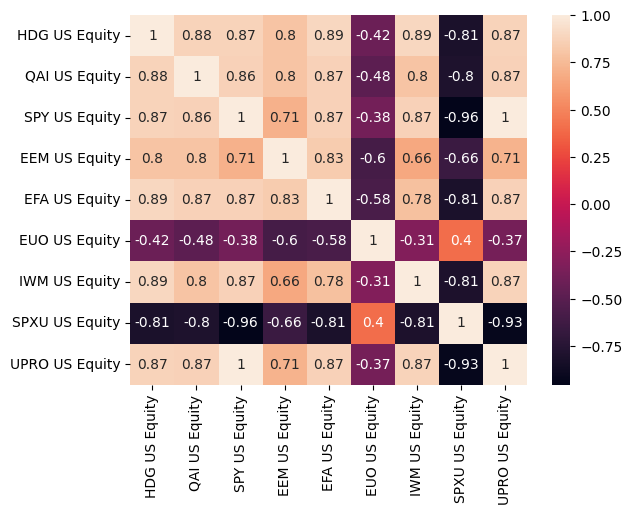

In [60]:
# Correlation matix

sns.heatmap(proshares_data.corr(), annot=True)

In [63]:
proshares_data.corr().loc["HDG US Equity"]

HDG US Equity     1.0000
QAI US Equity     0.8766
SPY US Equity     0.8736
EEM US Equity     0.8013
EFA US Equity     0.8949
EUO US Equity    -0.4192
IWM US Equity     0.8947
SPXU US Equity   -0.8148
UPRO US Equity    0.8730
Name: HDG US Equity, dtype: float64

### 6.

Explain how good is your replication, pointing out at least one good or bad argument related to each of the statistics mentioned in the bullet points above (thus, you should have at least 4 arguments).

# R squared

An R-squared value of 0.8419 indicates that approximately 84.19% of the variability in QAI's returns can be explained by the returns of the replication portfolio. 

However, 15.81% still unexplained, maybe there are other fators that are not accounted for. May not fully capture all the dynamics and risks associated with QAI.

# Alpha annualised
Alpha Annualised: -0.0062962. Replication underpormed the QAI. This means inefficiencies in the replication strategy, worst then the actual. However, it could mean that replication fully accounted for most of the alpha in QAI.

# Information ratio.
Good: Information ratio is mainly negative due to alpha being negative. However, given that it is still relatively small, means the volatility of the portfolio is reasonably small

Bad: A negative information ratio is problematic as it highlights that the replication is not only underperforming but is also doing so in a way that is inconsistent and less reliable. 

# Betas

Good: Beta to SPY is about 0.5, other betas are smaller. This means that the fatcors explaining QAI are quite spread out not only concentrated in one asset class. 

Bad: Wierd that is not having a higher beta to HDG which is a competitor. Generally low betas, meaning variance explained might generally be smaller as confirmed in R2.

# correlations

 A high positive correlation with QAI indicates that HDG and QAI tend to move in the same direction. This suggests that they may share similar investment strategies or exposures, particularly if QAI is aimed at replicating hedge fund strategies, as HDG might also be doing.
 Similarly high correlation with SPY, which tracks the S&P 500, suggests that HDG has significant exposure to large-cap U.S. equities, behaving similarly to the broader U.S. stock market. A strong negative correlation with SPXU, a triple inverse ETF to the S&P 500, means HDG tends to perform inversely to this ETF. Essentially, when the S&P 500 experiences negative returns (and SPXU gains), HDG loses value, highlighting its positive alignment with the broader U.S. stock market.The strong positive correlations with major equity indexes like SPY, IWM, EFA, and UPRO suggest HDG heavily mirrors the equity market performance, both U.S. and international. The negative correlations with inverse ETFs like EUO and SPXU highlight its vulnerability to certain economic shifts, especially in the U.S. and Europe.

***

# 4. 

The data in sheet `fx carry excess returns` has **excess** daily returns for trading currencies.
* You **do NOT need** to know anything about FX, currency, or the underlying strategies.
* Rather, just take these return series as given.

For the problems below, we will **only use** the `JPY` series.

### 1.

Calculate the `1%` VaR as follows...

Empirical VaR:
* At every point in time, calculate the `1st` quantile of the returns up to that point.
* No need to scale the answers.
  
Report the VaR for the final date of the sample.

In [64]:
fx_data = fa.load_data(filename="midterm_1_data.xlsx",
                       path="./data",
                       sheet_name="fx carry returns")
fx_data.set_index("date", inplace=True)
fx_data.head()


,JPY,EUR,GBP,MXN,CHF
date,,,,,
2019-01-07,-0.0018,0.0068,0.0042,0.0034,0.0076
2019-01-08,-0.0003,-0.0030,-0.0048,0.0003,-0.0018
2019-01-09,0.0052,0.0088,0.0056,0.0072,0.0068
2019-01-10,-0.0025,-0.0038,-0.0034,0.0054,-0.0103
2019-01-11,-0.0009,-0.0028,0.0075,-0.0003,0.0007


In [91]:
jpy_data = fx_data.loc[:,"JPY"]
quantile = 0.01
expanding_vol = jpy_data.expanding().quantile(quantile).shift(1)
combined_jpy_data = pd.concat([jpy_data, expanding_vol], axis=1)
combined_jpy_data.columns = ["JPY", "Expanding VAR"]
display(combined_jpy_data.tail(3))



,JPY,Expanding VAR
date,,
2024-08-01,0.0040,-0.0172
2024-08-02,0.0192,-0.0172
2024-08-05,0.0160,-0.0172


### 2.

Now calculate the `normal VaR` of `JPY` as follows,

$$\text{Normal VaR (1\%)} = -2.33\, \sigma_t$$

where $\sigma_t$ is estimated with
* rolling volatility.
* using a window of `233` days.
* without using a sample mean.

Report the VaR for the final `3 days` of the sample.

In [75]:
# Normal Var
window_size =233
jpy_vol = jpy_data.rolling(window=window_size,center=False).apply(lambda x: np.sqrt(np.sum(x**2)/ window_size)).shift(1)
jpy_var_normal = jpy_vol.apply(lambda x: -2.33*x)
jpy_var_normal.tail(3)

date
2024-08-01   -0.0134
2024-08-02   -0.0134
2024-08-05   -0.0136
Name: JPY, dtype: float64

### 3.

Now calculate the `normal VaR` of `JPY` as follows,

$$\text{Normal VaR (1\%)} = -2.33\, \sigma_t$$

where $\sigma_t$ is estimated with
* EWMA volatility
* using $\lambda = 0.94$.
* without using a sample mean.

Report the VaR for the final `3 days` of the sample.

In [76]:
# Exponential moving Avg
def ewma_volatility(data: pd.DataFrame, start_date: str, column_name:str, theta: float = 0.94, initial_sigma: float = 0.20 / np.sqrt(252)) -> pd.Series:
    """
    Calculate EWMA volatility.
    
    Args:
    data (pd.Series): Time series of returns.
    theta (float): Decay factor for the EWMA.
    initial_sigma (float): Initial volatility estimate.
    
    Returns:
    pd.Series: EWMA volatility of the returns.
    """
    calculation_data = data[column_name]
    sigma_squared = np.zeros_like(calculation_data)
    sigma_squared[0] = initial_sigma**2
    
    for t in range(1, len(calculation_data)):
        sigma_squared[t] = theta * sigma_squared[t-1] + (1 - theta) * calculation_data.iloc[t-1]**2
    new_data = pd.Series(np.sqrt(sigma_squared), index=data.index).loc[start_date:,]
    new_data.name = f"{column_name}_EWMA_volatility"

    
    return new_data

In [80]:
overall_vol = (jpy_data.apply(lambda x: x**2).sum() / len(jpy_data))**0.5 
print(overall_vol)

0.0057818328106658485


In [83]:
ewma_vol = ewma_volatility(data=fx_data, start_date="2010-01-01", column_name="JPY", theta=0.94, initial_sigma=0.005)
ewma_var = ewma_vol.apply(lambda x: -2.33*x)
display(ewma_var.tail(3))

date
2024-08-01   -0.0178
2024-08-02   -0.0174
2024-08-05   -0.0201
Name: JPY_EWMA_volatility, dtype: float64

### 4.

Make a plot of the three timeseries of your VaR estimates.

Succinctly point out the pros / cons of these approaches.

In [99]:
full_results = pd.concat([combined_jpy_data["Expanding VAR"].to_frame("Expanding Var historical"), jpy_var_normal.to_frame("Var rolling"), ewma_var], axis=1)


Exceedances and Hit Ratios per model:
                          Exceedances  Hit Rate
Expanding Var historical      32.0000    0.0245
Var rolling                   27.0000    0.0207
JPY_EWMA_volatility           26.0000    0.0199
Expected Exceedances: 13.05
Expected Hit Ratio: 0.01


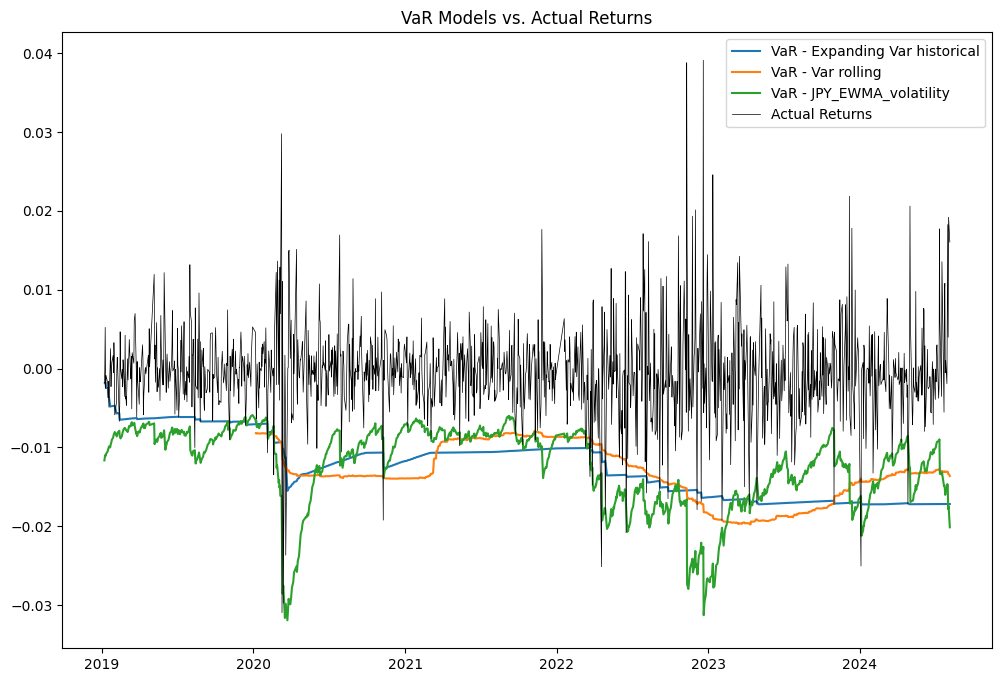

In [100]:
# Define the function to calculate exceedances and hit ratio
def calculate_exceedances_and_hit_ratio(var_series, returns):
    exceedances = np.sum(returns < var_series)
    hit_rate = exceedances / len(returns)
    return pd.Series([exceedances, hit_rate], index=["Exceedances", "Hit Rate"])

# Assuming actual_returns and full_results are defined and valid
actual_returns = jpy_data  

results_df = full_results.apply(lambda col: calculate_exceedances_and_hit_ratio(col, actual_returns)).T

# Assuming a 99% VaR, we expect 1% exceedances
expected_exceedances = len(actual_returns) * 0.01
expected_hit_ratio = 0.01

# Output the results
print("Exceedances and Hit Ratios per model:")
print(results_df)
print("Expected Exceedances:", expected_exceedances)
print("Expected Hit Ratio:", expected_hit_ratio)

# Plotting the VaR series and actual returns for visual inspection
plt.figure(figsize=(12, 8))
for col in full_results.columns:
    plt.plot(full_results[col], label=f'VaR - {col}')
plt.plot(actual_returns, 'k', label='Actual Returns', linewidth=0.5)
plt.legend()
plt.title("VaR Models vs. Actual Returns")
plt.show()

Rolling VaR uses a fixed-size moving window to estimate risk based on the most recent data points, typically calculating VaR using a window of recent returns. It is timely, utilising most recent market conditions, ignoring very old data, making it adaptable. However, downside it is sensitive to size of window which is an arbitrary statistic. May overfit to recent market conditions and not reflect longer-term trends. Too small a window might not capture enough data to represent the risk accurately. Requires continuous updating and sufficient data points within the window to maintain reliability.

Historical VAr calculation method calculates VaR directly from the full range of historical data without modeling or assumptions about the statistical distribution of returns. Non-parametric, meaning it Does not assume a normal distribution of returns, making it potentially more accurate in capturing tail risks. However, it is sensitive to sample size. If you use a small sample to estimate the VaR, your VaR statsitic is not relaible, poorly esimated. Parametric methods use full range of data.

EWMA VAR can be tweaked to be resposnive to recent data or more to older data. By applying a decay factor. EWMA gives more weight to more recent data points. This makes the model highly responsive to recent market changes, which is particularly beneficial during periods of high volatility or market shocks. EWMA smooths out the data, reducing the noise in volatility estimates. This can provide a clearer signal in the presence of random fluctuations in market prices. However, again the usage of a parameter is based on judgement, sensitive to decay factor. Assumption of normality here, and might be oversesntive to recent data.

### 5.

What statistic do we use to judge the performance of a VaR model?

Estimate and report this statistic across the VaR methods.

Which VaR model do you find is best?

Exceedances and Hit Rate per model:
                          Exceedances  Hit Rate
Expanding Var historical      32.0000    0.0245
Var rolling                   27.0000    0.0207
JPY_EWMA_volatility           26.0000    0.0199
Expected Exceedances: 13.05
Expected Hit Ratio: 0.01


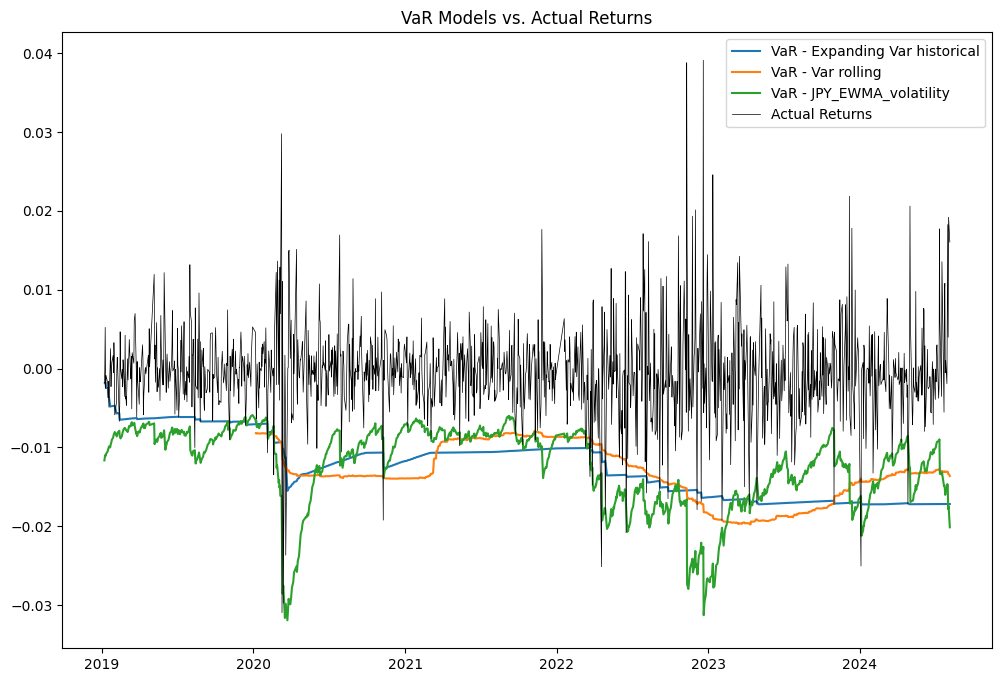

In [103]:
# Define the function to calculate exceedances and hit ratio
def calculate_exceedances_and_hit_ratio(var_series, returns):
    exceedances = np.sum(returns < var_series)
    hit_rate = exceedances / len(returns)
    return pd.Series([exceedances, hit_rate], index=["Exceedances", "Hit Rate"])

# Assuming actual_returns and full_results are defined and valid
actual_returns = jpy_data  

results_df = full_results.apply(lambda col: calculate_exceedances_and_hit_ratio(col, actual_returns)).T

# Assuming a 99% VaR, we expect 1% exceedances
expected_exceedances = len(actual_returns) * 0.01
expected_hit_ratio = 0.01

# Output the results
print("Exceedances and Hit Rate per model:")
print(results_df)
print("Expected Exceedances:", expected_exceedances)
print("Expected Hit Ratio:", expected_hit_ratio)

# Plotting the VaR series and actual returns for visual inspection
plt.figure(figsize=(12, 8))
for col in full_results.columns:
    plt.plot(full_results[col], label=f'VaR - {col}')
plt.plot(actual_returns, 'k', label='Actual Returns', linewidth=0.5)
plt.legend()
plt.title("VaR Models vs. Actual Returns")
plt.show()

In [105]:
pmh.calc_var_cvar_summary(returns = jpy_data,
                          quantile = 0.01,
                          window = 233,
                          return_hit_ratio=True,
                          z_score=-2.33,
                          ewma_initial_vol=0.005)

c:\Users\Andik\anaconda3\envs\chicago-aug-review\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


,Hit Ratio,Hit Ratio Error,Hit Ratio Absolute Error
Rolling 233 Historical VaR (1.00%),0.0187,0.8657,0.8657
"GARCH(1, 1) Parametric VaR (1.00%)",0.0000,-1.0000,1.0000
Expanding 233 Historical VaR (1.00%),0.0205,1.0522,1.0522
EWMA 0.94 Parametric VaR (1.00%),0.0224,1.2388,1.2388
Rolling 233 Parametric VaR (1.00%),0.0252,1.5187,1.5187
Expanding 233 Parametric VaR (1.00%),0.0261,1.6119,1.6119


Usage of hit ratio to judge the performance of the var model. The best method seems to be EWMA method. It has the closest hit ratio to 0.01 which is the target.

***